In [1]:
import os
import shutil
from glob import glob

import numpy as np

import pandas as pd

from PIL import Image
import PIL

import random
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense ,BatchNormalization, Activation
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)


In [3]:
filenames = os.listdir('faces_images/faces_images')

In [60]:
train_csv = pd.read_csv('faces_images/train_vision.csv',names=['filename','category'])
train_csv.shape
df = train_csv[1:]

In [61]:
len(df)

5850

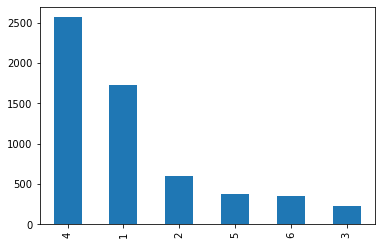

In [6]:
df['category'].value_counts().plot.bar()

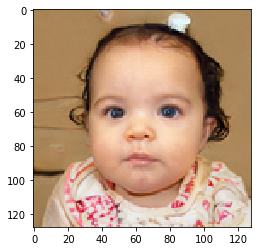

In [7]:
sample = random.choice(filenames)
image = load_img('faces_images/faces_images/'+sample)
plt.imshow(image)

In [8]:
test_csv = pd.read_csv('faces_images/test_vision.csv',names=['filename'])
test_csv = test_csv[1:]
test_csv.shape

(2000, 1)

In [9]:
test_csv.head()

,filename
1,face_2624.png
2,face_3385.png
3,face_5015.png
4,face_6715.png
5,face_6171.png


# 모델 생성

In [10]:
model = Sequential()

#Layer 1
model.add(Conv2D(32,(3,3) , activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#Fully connected
model.add(Flatten())
model.add(Dense(512,activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

# 콜백함수 생성

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
earlystop = EarlyStopping(patience =10)

In [15]:
learing_rate_reduction =  ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
callbacks = [earlystop, learing_rate_reduction]

# 데이터 전처리

In [17]:
df['category'] = df['category'].replace({'1':'m1' , '2':'m2' , '3':'m3', '4':'w1', '5':'w2' ,'6':'w3'})
df.head()

c:\users\taxijjang\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,filename,category
1,face_3267.png,m1
2,face_587.png,w1
3,face_6585.png,w1
4,face_3094.png,w1
5,face_1170.png,w1


In [18]:
train_df , validate_df = train_test_split(df,test_size = 0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

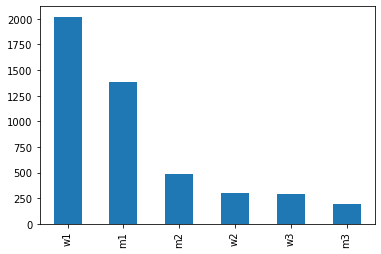

In [19]:
train_df['category'].value_counts().plot.bar()

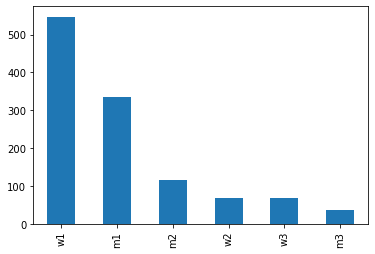

In [20]:
validate_df['category'].value_counts().plot.bar()

In [21]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "faces_images/faces_images", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4680 validated image filenames belonging to 6 classes.


In [23]:
validation_datagen = ImageDataGenerator(rescale= 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "faces_images/faces_images",
    x_col ='filename',
    y_col ='category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size=batch_size
)

Found 1170 validated image filenames belonging to 6 classes.


In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "faces_images/faces_images",
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


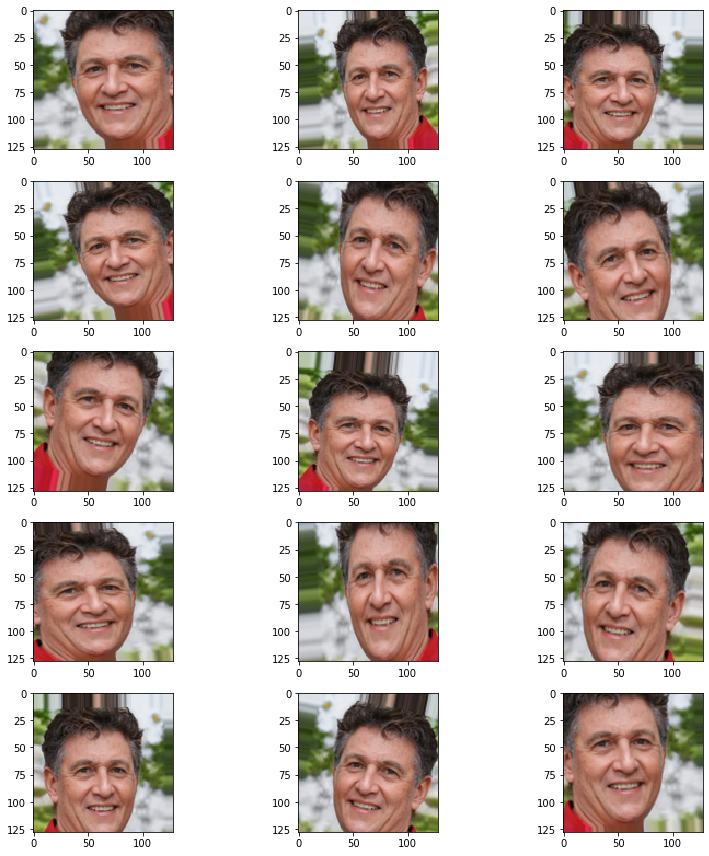

In [25]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

# 모델 훈련

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [114]:
model.save_weights("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

# 모델 로드

In [31]:
os.listdir()

['.ipynb_checkpoints',
 'faces_images',
 'new_model.h5',
 'Untitled.ipynb',
 '프로그래머스 컴퓨터비전 - 2.ipynb']

In [131]:
import tqdm
from tensorflow.keras.models import load_model
#m1 = load_model('model.h5')

In [106]:
test_path = os.listdir('faces_images')
test_csv = pd.read_csv('faces_images/test_vision.csv',names=['filename'])
test_df = test_csv[1:]

nb_samples = test_df.shape[0]
test_df.head()

,filename
1,face_2624.png
2,face_3385.png
3,face_5015.png
4,face_6715.png
5,face_6171.png


In [107]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "faces_images/faces_images/",
    x_col ='filename',
    y_col = None,
    class_mode=None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle=False
)

Found 2000 validated image filenames.


In [115]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [116]:
test_df['category'] = np.argmax(predict,axis=-1)

c:\users\taxijjang\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] =test_df['category'].replace(label_map)

c:\users\taxijjang\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
test_df['category'] = test_df['category'].replace({'m1':1,'m2':2,'m3':3,'w1':4,'w2':5,'w3':6})

c:\users\taxijjang\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
res = test_df['category'].to_csv('faces_images/result.csv',header=False,index=False)

1       1
2       1
3       1
4       1
5       1
       ..
1996    1
1997    1
1998    5
1999    4
2000    1
Name: category, Length: 2000, dtype: int64

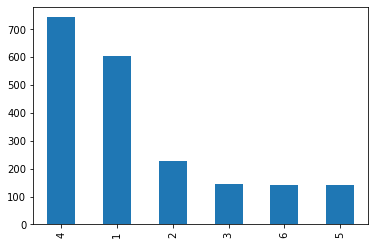

In [120]:
test_df['category'].value_counts().plot.bar()

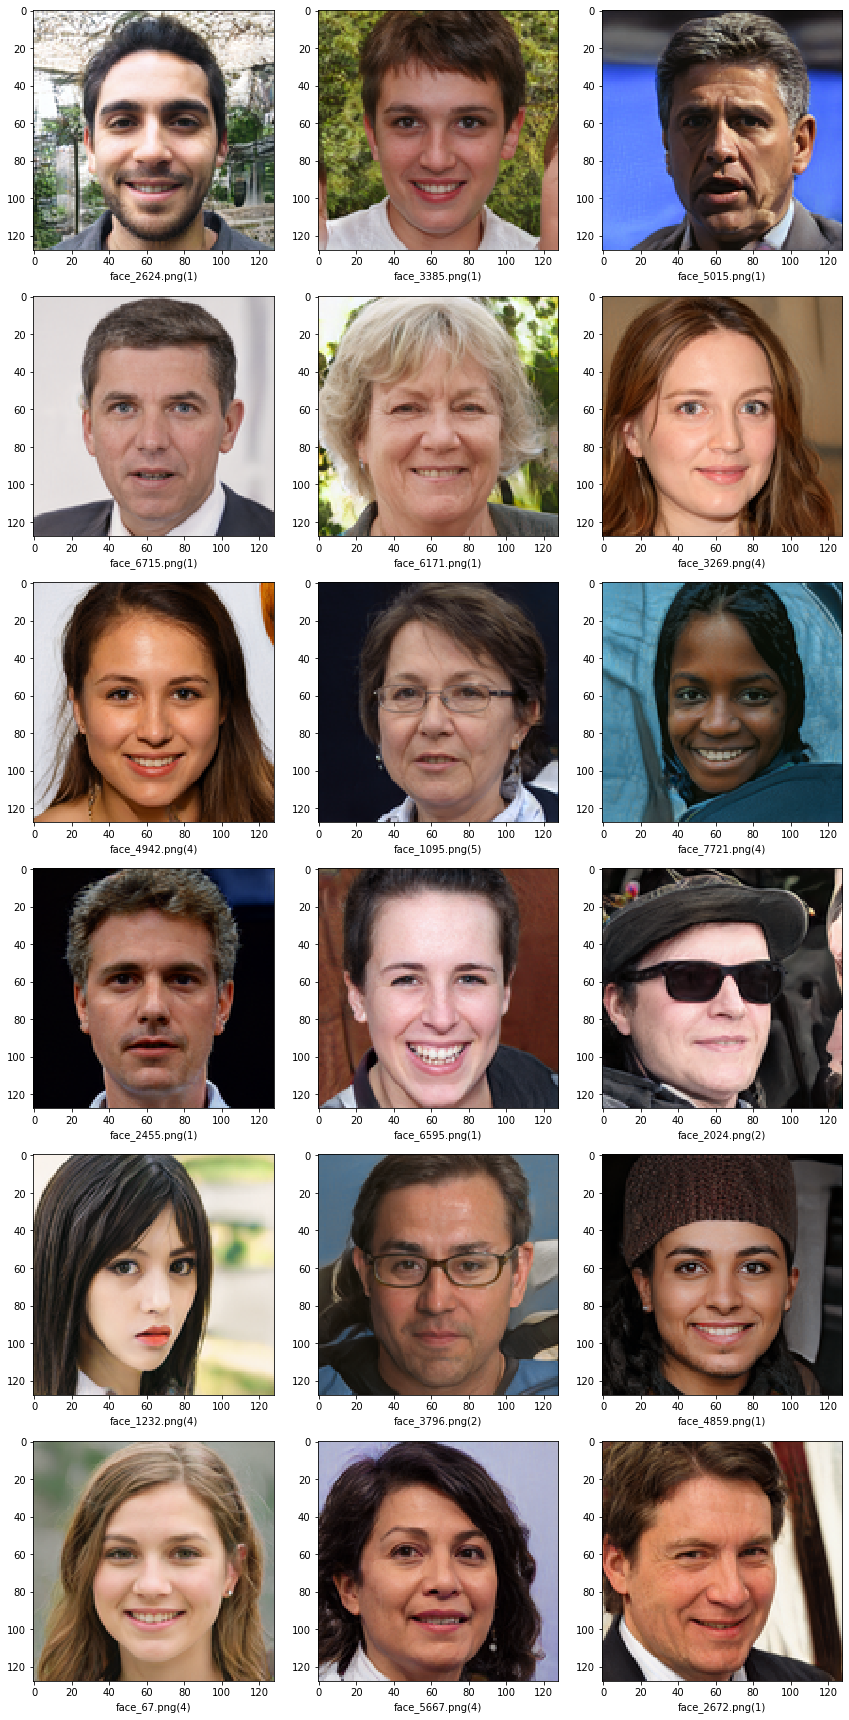

In [129]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize = (12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("faces_images/faces_images/"+filename, target_size= IMAGE_SIZE)
    plt.subplot(6,3,index)
    plt.imshow(img)
    plt.xlabel(filename + '('+ "{}".format(category)+')')
plt.tight_layout()
plt.show()